In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import piezo
import ast
from scipy import stats
import statsmodels.api as sm
import pymc as pm
import arviz as az

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
import json
from protocols.BuildCatalogue import BuildCatalogue

from scipy.stats import norm

## Loss of function in Rv0678

The WHO have used aggregate rules for all loss of function mutations in Rv0678 and pepQ, solely based off literature evidence. The question is, does the data suggest this approach is valid and should we be doing the same?   

If we can demonstrate sufficient phenotype homogeneity and a strong mean penetration, then an additional aggregate rule could be justified. 

However 4/22 and 70/324 Rv0678 premature stops and frameshifts are susceptible (in the catalogue), which seems quite high if we're going to assume they all have the same effect.

Lets look at the proportions of resistant outcomes and compare to the background rate.

The total background rates are heavily skewed as CRyPTIC I contains very little background R - for a generalisable catalogueu building approach, that's probably fine as we don't want to overcomplicate data prep - but when examining LOFs specifically, should use those mutataions backgrounds from the context in which they were sampled (ie just the NICD background rates)

### Proportions

In [14]:
# Extract lof rows from the catalogue and associated evidence

rules = ["*_fs", "*!"]

catalogue = pd.read_csv("catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv")

with open("../../tb-cat-builder/wildcards/bdq_wildcards.json", "r") as f:
    wildcards = json.load(f)

aggregate_vars = {}
for rule in rules:
    aggregate_rule = piezo.ResistanceCatalogue(f"./temp/bdq_Rv0678@{rule}.csv")
    for i in catalogue.index:
        mutation = catalogue["MUTATION"][i]
        if (mutation != aggregate_rule) and (mutation not in wildcards.keys()):
            if aggregate_rule.predict(mutation)["BDQ"] == "R":
                evidence = ast.literal_eval(catalogue["EVIDENCE"][i])
                aggregate_vars[mutation] = [
                    evidence["solo_R"],
                    evidence["solo_S"],
                    evidence["background_R"],
                    evidence["background_S"],
                ]

cont_df = {}
for mut, ev in aggregate_vars.items():
    cont_df[mut] = {
        "R": ev[0],
        "S": ev[1],
        "'R": ev[2],
        "'S": ev[3],
        "n_total": ev[0] + ev[1],
    }

contingency_df = pd.DataFrame(cont_df).T
contingency_df["Gene"] = [i.split("@")[0] for i in contingency_df.index]


def extract_position(mutation):
    parts = mutation.split("@")[1]
    position = "".join(filter(str.isdigit, parts.split("_")[0]))
    return int(position)

contingency_df["Position"] = contingency_df.index.map(extract_position)


#pool rows with n_total < 3
to_pool_df = contingency_df[contingency_df['n_total'] < 4]
remaining_df = contingency_df[contingency_df['n_total'] >= 4]

pooled_row = to_pool_df.agg({
    'R': 'sum',
    'S': 'sum',
    "'R": 'sum',
    "'S":'sum',
    'n_total': 'sum'
}).to_frame().T

pooled_row.index = ['Rv0678@RARE']
high_freq = pd.concat([remaining_df, pooled_row])


In [15]:
#calculate proportions with wilson confidence intervals
def wilson(var):
    successes, n = var['R'], var['n_total']
    proportion = successes / n
    z = norm.ppf(1 - 0.05 / 2)
    denom = 1 + (z**2 / n)
    centre_adjusted_prob = proportion + (z**2 / (2 * n))
    adjusted_sd = z * np.sqrt((proportion * (1 - proportion) / n) + (z**2 / (4 * n**2)))

    lower = (centre_adjusted_prob - adjusted_sd)/denom
    upper = (centre_adjusted_prob + adjusted_sd)/denom

    return pd.Series([proportion, lower, upper], index=['proportion', 'lower_bound', 'upper_bound'])

high_freq[['Proportion', 'lower_bound', 'upper_bound']] = high_freq.apply(wilson, axis=1)

high_freq

,R,S,'R,'S,n_total,Gene,Position,Proportion,lower_bound,upper_bound
Rv0678@193_del_g,12,6,136,10683,18,Rv0678,193.0,0.666667,0.437495,0.837212
Rv0678@141_ins_c,124,27,136,10683,151,Rv0678,141.0,0.821192,0.752344,0.874103
Rv0678@138_ins_g,35,12,136,10683,47,Rv0678,138.0,0.744681,0.604918,0.847468
Rv0678@192_ins_g,35,46,136,10683,81,Rv0678,192.0,0.432099,0.329721,0.540626
Rv0678@465_ins_c,3,1,136,10683,4,Rv0678,465.0,0.750000,0.300642,0.954413
Rv0678@132_ins_gt,12,2,136,10683,14,Rv0678,132.0,0.857143,0.600586,0.959906
Rv0678@423_ins_c,12,1,136,10683,13,Rv0678,423.0,0.923077,0.666860,0.986290
Rv0678@140_ins_tc,13,2,136,10683,15,Rv0678,140.0,0.866667,0.621180,0.962639
Rv0678@148_ins_g,6,0,136,10683,6,Rv0678,148.0,1.000000,0.609666,1.000000
Rv0678@136_ins_g,5,0,136,10683,5,Rv0678,136.0,1.000000,0.565518,1.000000


In [16]:
# get background rate for BDQ resistance benchmark
mutations = pd.read_csv("./temp/relevant_genes.csv")
phenotypes = pd.read_pickle(
    "./data/crypticv2.1.1/DST_MEASUREMENTS.pkl.gz"
).reset_index()
genomes = pd.read_pickle("./data/crypticv2.1.1/GENOMES.pkl.gz").reset_index()

mutations["GENE_MUT"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
mutations["IS_SYNONYMOUS"] = mutations["GENE_MUT"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()
mutations = mutations[mutations.GENE.isin(["Rv0678", "pepQ", "atpE"])]

phenos = phenotypes[
    (~phenotypes.PHENOTYPE.isna())
    & (phenotypes.QUALITY.isin(["HIGH", 'MEDIUM']))
    & (phenotypes.PHENOTYPE != "U")
]
phenos = phenos[
    (phenos.DRUG == "BDQ")
    & (
        ((phenos.METHOD_3 == "MGIT960") & (phenos.SOURCE == "NICD"))
    )
]

samples = pd.merge(genomes, phenos, on="UNIQUEID", how="inner")[
    ["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]
]
all_data = pd.merge(samples, mutations, on="UNIQUEID", how="left")

# Group by UNIQUEID, check for mutations, and count R and S occurrences
def count_phenotypes(group):
    if group.MUTATION.isna().all():
        return group.PHENOTYPE.iloc[0]
    return pd.NA

background = all_data.groupby('UNIQUEID').apply(count_phenotypes).dropna().value_counts().to_dict()
background = background['R']/(background['R']+background['S'])


In [17]:
background

0.24829157175398633

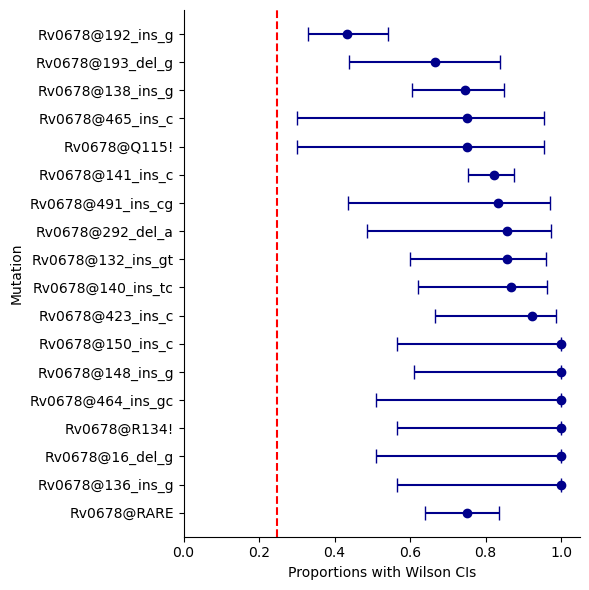

In [18]:


#high frequency mutations:
high_freq = high_freq.sort_values(by="Proportion", ascending=False)

#move rare mutations row to the bottom
rare_row = high_freq.loc[['Rv0678@RARE']]
high_freq = high_freq.drop('Rv0678@RARE')
high_freq = pd.concat([rare_row, high_freq])

fig, ax = plt.subplots(figsize=(6, 6)) 

xerr = [abs(high_freq['Proportion'] - high_freq['lower_bound']), abs(high_freq['upper_bound'] - high_freq['Proportion'])]
ax.errorbar(x=high_freq['Proportion'], y=np.arange(len(high_freq)), xerr=xerr, fmt='o', color='darkBlue', capsize=5)
ax.set_yticks(np.arange(len(high_freq)))
ax.set_yticklabels([i if len(i)< 20 else i[:20] for i in high_freq.index ])

plt.axvline(x=background, color='red', linestyle='--')  # Add a line at log OR = 0 (OR = 1) for reference

plt.xlabel('Proportions with Wilson CIs')
plt.ylabel('Mutation')
plt.tight_layout()
plt.xlim(0, 1.05)
sns.despine()

plt.show()


In [19]:
background

0.24829157175398633

In [20]:
#calucalte odds and log odds ratios for each row

background = all_data.groupby('UNIQUEID').apply(count_phenotypes).dropna().value_counts().to_dict()

contingency_df["'R"] = background['R']
contingency_df["'S"] = background['S']

#pool rows with n_total < 3
to_pool_df = contingency_df[contingency_df['n_total'] < 4]
remaining_df = contingency_df[contingency_df['n_total'] >= 4]

pooled_row = to_pool_df.agg({
    'R': 'sum',
    'S': 'sum',
    "'R": 'sum',
    "'S":'sum',
    'n_total': 'sum'
}).to_frame().T

pooled_row.index = ['Rv0678@RARE']
high_freq = pd.concat([remaining_df, pooled_row])
#high_freq = remaining_df

odds_ratios = []
for i in high_freq.index:
    if np.sum([high_freq['R'][i], high_freq['S'][i]]):
        # need to additive continuity correction to avoid any 'zero' cells
        odds_ratios.append(((high_freq['R'][i]+0.5)*(high_freq["'S"][i]+0.5))/((high_freq['S'][i]+0.5)*(high_freq["'R"][i]+0.5)))

log_odds = np.log(odds_ratios)
high_freq['OR'] = odds_ratios
high_freq['log_OR'] = log_odds


#calculate 95% confidence intervals for log odds and log odds ratios
high_freq['SE'] = np.sqrt(1/(high_freq['R']+0.5) + 1/(high_freq['S']+0.5) + 1/(high_freq["'R"]+0.5) + 1/(high_freq["'S"]+0.5))
high_freq['log_CI_lower'] = high_freq['log_OR'] - (1.96 * high_freq['SE'])
high_freq['log_CI_upper'] = high_freq['log_OR'] + (1.96 * high_freq['SE'])

high_freq

high_freq.sort_values(by=['Position'], inplace=True, ascending=False)



high_freq

,R,S,'R,'S,n_total,Gene,Position,OR,log_OR,SE,log_CI_lower,log_CI_upper
Rv0678@491_ins_cg,5,1,109,330,6,Rv0678,491.0,11.066971,2.403965,0.927708,0.585657,4.222274
Rv0678@465_ins_c,3,1,109,330,4,Rv0678,465.0,7.042618,1.951980,0.982110,0.027045,3.876915
Rv0678@464_ins_gc,4,0,109,330,4,Rv0678,464.0,27.164384,3.301907,1.494784,0.372129,6.231684
Rv0678@423_ins_c,12,1,109,330,13,Rv0678,423.0,25.152207,3.224946,0.871106,1.517579,4.932312
Rv0678@292_del_a,6,1,109,330,7,Rv0678,292.0,13.079148,2.571019,0.912508,0.782503,4.359535
Rv0678@193_del_g,12,6,109,330,18,Rv0678,193.0,5.804355,1.758609,0.495988,0.786472,2.730745
Rv0678@192_ins_g,35,46,109,330,81,Rv0678,192.0,2.304267,0.834762,0.248661,0.347386,1.322139
Rv0678@150_ins_c,5,0,109,330,5,Rv0678,150.0,33.200913,3.502577,1.481208,0.599410,6.405745
Rv0678@148_ins_g,6,0,109,330,6,Rv0678,148.0,39.237443,3.669631,1.471735,0.785031,6.554232
Rv0678@141_ins_c,124,27,109,330,151,Rv0678,141.0,13.664508,2.614802,0.237811,2.148693,3.080911


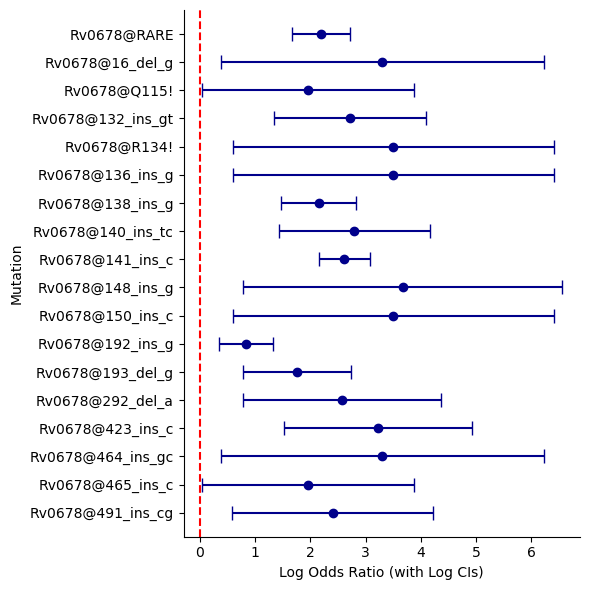

In [21]:
fig, ax = plt.subplots(figsize=(6, 6)) 
xerr = [high_freq['log_OR'] - high_freq['log_CI_lower'], high_freq['log_CI_upper'] - high_freq['log_OR']]
ax.errorbar(x=high_freq['log_OR'], y=np.arange(len(high_freq)), xerr=xerr, fmt='o', color='darkBlue', capsize=5)
ax.set_yticks(np.arange(len(high_freq)))
ax.set_yticklabels([i if len(i)< 20 else i[:20] for i in high_freq.index ])

plt.axvline(x=0, color='red', linestyle='--')  # Add a line at log OR = 0 (OR = 1) for reference

plt.xlabel('Log Odds Ratio (with Log CIs)')
plt.ylabel('Mutation')
plt.tight_layout()
sns.despine()

plt.show()

Odds ratio represent probability by prvodiding an estimate of relationship between R and S (probabilty that R occurs to the probability that it doesnt). Odds ratios have skewed distributions as can't be negative, therefore us log odds (approximates a normal distribution).

We see considerably heterogeneity, but it is all within one side of the phenotype effects line - these effect sizes would suggest aggregation is justified in light of the NICD background rate. 

Proportions all above background, but more heterogenous than I would expect.

Let's put some numbers on it:

In [22]:
def calculate_q(effect_sizes, variances):
    # Calculate weights as the inverse of variances
    weights = 1 / variances
    
    # Calculate the weighted mean of effect sizes
    weighted_mean_effect_size = np.sum(weights * effect_sizes) / np.sum(weights)
    
    # Calculate the Q statistic as the sum of weighted squared differences 
    # between individual effect sizes and the weighted mean effect size
    q = np.sum(weights * (effect_sizes - weighted_mean_effect_size) ** 2)
    return q

def calculate_i2(q, df):
    i2 = ((q - df) / q) * 100
    i2 = max(0, i2)
    return i2

In [23]:
q = calculate_q(high_freq.log_OR, high_freq.SE)
calculate_i2(q, len(high_freq) - 1)


1.2203768320647814

In [24]:
q

17.210027184552327

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("log_OR ~ 1", high_freq, groups=high_freq.index, re_formula="~1")
mdf = md.fit()
tau_squared = mdf.cov_re.iloc[0, 0]
tau_squared


/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


0.294670153690189

In [26]:
mdf